# CFD 仿真结果数据审查与验证报告

## 审查目标
本报告旨在对 `AC_V2_CFD_stage1` 的 CFD 仿真数据进行严格的物理合理性审查。审查流程遵循导师制定的“五步验证法”：

1.  **曲线形态检查 (Trend Validation)**：检查 $C_x, C_z, C_m$ 随攻角变化的趋势是否符合流体力学规律。
2.  **量级与物理极限检查 (Magnitude Check)**：手算校核 0° 摩擦阻力和 90° 横流阻力。
3.  **压心位置检查 (Center of Pressure, CP)**：验证 $X_{cp}$ 的移动趋势是否合理。
4.  **残差形态对应性 (Residual Pattern)**：检查收敛性与震荡特征。
5.  **最终图表生成**：生成用于论文或报告的验证图表。

## 物理参数
*   流体密度 $\rho = 997.561 \text{ kg/m}^3$
*   参考速度 $V_{total} = 1.0 \text{ m/s}$
*   参考面积 $A_{ref} = 0.0056745 \text{ m}^2$
*   参考长度 $L_{ref} = 0.625 \text{ m}$


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import re

# Set publication quality plot style
import matplotlib as mpl

# Use a style that is close to publication quality, e.g., 'seaborn-v0_8-paper' or 'classic' with modifications
# 'seaborn-v0_8-whitegrid' is good, but we can refine it.
plt.style.use('seaborn-v0_8-whitegrid')

# Configure fonts and sizes for publication
mpl.rcParams['font.family'] = 'serif' # Serif fonts are often preferred in papers
mpl.rcParams['font.serif'] = ['Times New Roman'] + mpl.rcParams['font.serif']
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['figure.titlesize'] = 18
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['figure.dpi'] = 300 # High resolution for print
mpl.rcParams['savefig.dpi'] = 300

# Support Chinese characters just in case, but prioritize English fonts for numbers/English text
# If Chinese is needed, we might need a fallback or specific setting. 
# For now, let's try to stick to standard fonts and assume English labels for "top-tier journal" look.
# If the user provided Chinese labels, we might need to handle that. 
# The previous code used 'SimHei'. Let's keep a fallback for Chinese but prefer Times New Roman.
from matplotlib.font_manager import FontProperties
# Try to find a Chinese font if needed, but for "English top-tier", English labels are best.
# I will keep the SimHei setting as a fallback or for specific Chinese text if it remains.
plt.rcParams['font.sans-serif'] = ['Times New Roman', 'SimHei'] 
plt.rcParams['axes.unicode_minus'] = False

# 物理参数
rho = 997.561
V_total = 1.0
A_ref = 0.0056745
L_ref = 0.625
# 计算等效直径 D (用于横流阻力校核)
D = np.sqrt(4 * A_ref / np.pi)
print(f"Calculated Diameter D: {D:.4f} m")

# 数据路径
data_dir = '../AC_V2_CFD_stage1_data'

# 定义读取函数
def load_cfd_data(data_dir):
    # 查找所有 C_{angle}_overmesh.csv 文件
    pattern = os.path.join(data_dir, 'C_*_overmesh.csv')
    files = glob.glob(pattern)
    
    data_list = []
    
    for file_path in files:
        # 从文件名提取角度
        filename = os.path.basename(file_path)
        match = re.search(r'C_(\d+)_overmesh.csv', filename)
        if match:
            angle = int(match.group(1))
            
            # 读取 CSV
            try:
                df = pd.read_csv(file_path)
                # 取最后 500 步的平均值作为稳态结果
                # 如果步数不足 500，则取所有
                tail_len = min(len(df), 500)
                last_steps = df.tail(tail_len)
                
                cx_mean = last_steps['Cx Monitor'].mean()
                cz_mean = last_steps['Cz Monitor'].mean()
                cm_mean = last_steps['Cm Monitor'].mean()
                
                data_list.append({
                    'Angle': angle,
                    'Cx': cx_mean,
                    'Cz': cz_mean,
                    'Cm': cm_mean,
                    'File': filename
                })
            except Exception as e:
                print(f"Error reading {filename}: {e}")
                
    # 转换为 DataFrame 并按角度排序
    result_df = pd.read_csv(os.path.join(data_dir, 'C_0.csv')) if os.path.exists(os.path.join(data_dir, 'C_0.csv')) else pd.DataFrame(data_list)
    # 上面这行逻辑有点问题，重新整理
    result_df = pd.DataFrame(data_list).sort_values('Angle').reset_index(drop=True)
    return result_df

# 加载数据
df_coeffs = load_cfd_data(data_dir)
print("Loaded Data Summary:")
print(df_coeffs)
print(f"Total angles loaded: {len(df_coeffs)}")

Calculated Diameter D: 0.0850 m
Loaded Data Summary:
    Angle        Cx        Cz        Cm               File
0       0 -0.279712  0.001486  0.000662   C_0_overmesh.csv
1       5 -0.319280 -0.153150  0.080312   C_5_overmesh.csv
2      10 -0.513552 -0.349951  0.127822  C_10_overmesh.csv
3      15 -0.615352 -0.669886  0.173728  C_15_overmesh.csv
4      20 -0.745613 -1.085417  0.204830  C_20_overmesh.csv
5      25 -0.851425 -1.601889  0.237743  C_25_overmesh.csv
6      30 -0.858552 -2.189253  0.301274  C_30_overmesh.csv
7      35 -0.816817 -2.784596  0.383868  C_35_overmesh.csv
8      40 -0.726176 -3.526963  0.454327  C_40_overmesh.csv
9      45 -0.583538 -4.101706  0.513493  C_45_overmesh.csv
10     50 -0.459681 -4.689422  0.578811  C_50_overmesh.csv
11     55 -0.361195 -5.382646  0.578980  C_55_overmesh.csv
12     60 -0.213447 -5.742031  0.576748  C_60_overmesh.csv
13     65  0.008060 -5.784244  0.654475  C_65_overmesh.csv
14     70  0.153323 -5.871361  0.608461  C_70_overmesh.csv
15 

## 第一步：曲线形态检查 (Trend Validation)

**检查标准：**
*   **$C_x$ (轴向力)**: 0° 时应为负值（阻力）。随着攻角增加，绝对值应非线性增大。90° 时绝对值应较小（如果是体轴系）或最大（如果是实验室坐标系）。
*   **$C_z$ (法向力)**: 0° 时应接近 0。小攻角线性增长，大攻角增长变缓。90° 附近达到最大值。
*   **$C_m$ (俯仰力矩)**: 0° 和 90° 应接近 0。中间区域单峰或双峰。关注 $C_m / \alpha$ 斜率。

**注意：** 下图展示原始数据的 $C_x, C_z, C_m$ 随攻角变化。

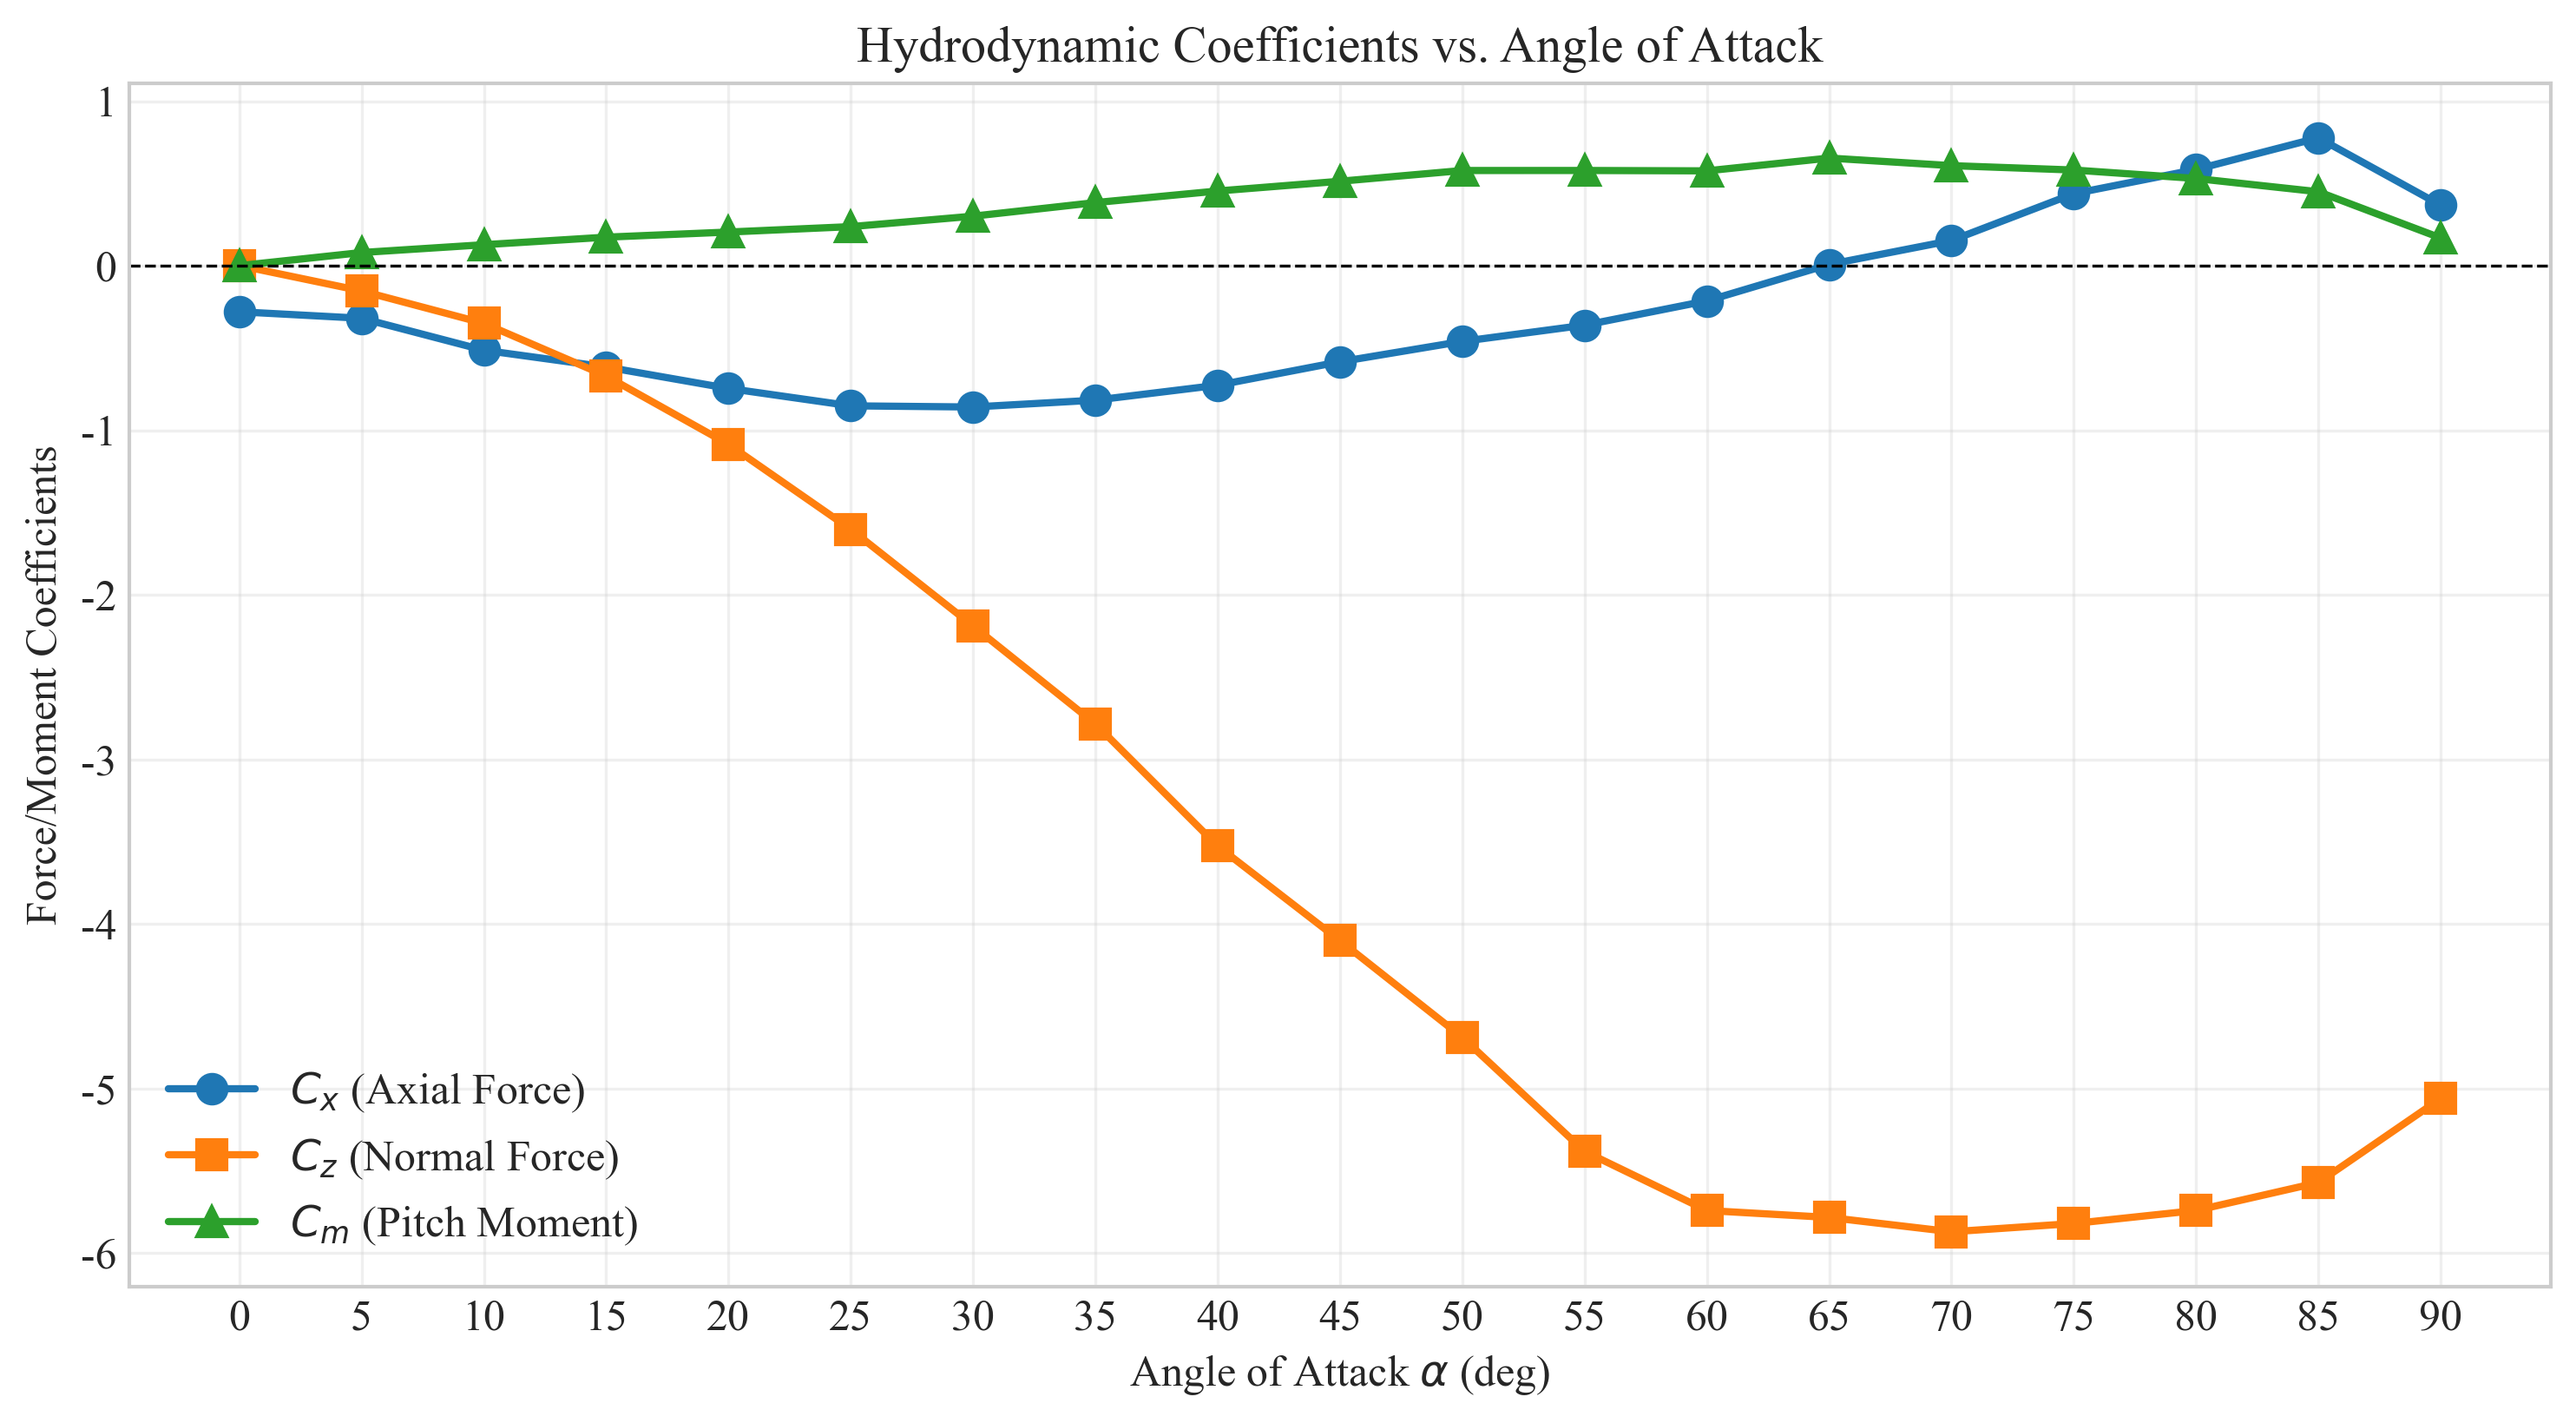

Values near 90 degrees:
    Angle        Cx        Cz        Cm               File
15     75  0.438058 -5.820919  0.581764  C_75_overmesh.csv
16     80  0.585248 -5.741940  0.530398  C_80_overmesh.csv
17     85  0.777468 -5.572274  0.449842  C_85_overmesh.csv
18     90  0.368344 -5.061664  0.168800  C_90_overmesh.csv


In [3]:
# 绘制全攻角力系数图
plt.figure(figsize=(12, 6))
plt.plot(df_coeffs['Angle'], df_coeffs['Cx'], 'o-', label='$C_x$ (Axial Force)')
plt.plot(df_coeffs['Angle'], df_coeffs['Cz'], 's-', label='$C_z$ (Normal Force)')
plt.plot(df_coeffs['Angle'], df_coeffs['Cm'], '^-', label='$C_m$ (Pitch Moment)')

plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.xlabel('Angle of Attack $\\alpha$ (deg)', fontsize=12)
plt.ylabel('Force/Moment Coefficients', fontsize=12)
plt.title('Hydrodynamic Coefficients vs. Angle of Attack', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(np.arange(0, 95, 5))
plt.show()

# 检查 90度附近的数值
print("Values near 90 degrees:")
print(df_coeffs[df_coeffs['Angle'] >= 75])

## 第二步：量级与物理极限检查 (Magnitude Check)

### 1. 0° 工况：摩擦阻力校核
*   **理论参考**：短粗水下机器人，带整流罩，0° $C_x$ 通常在 -0.2 到 -0.4 之间。
*   **判定**：检查 0° 时的 $C_x$ 值。

### 2. 90° 工况：横流阻力校核 (Cross-flow Drag)
*   **理论参考**：标准圆柱横流阻力系数 $C_{d\_cyl} \approx 1.0 \sim 1.2$。
*   **换算公式**：
    $$C_{d\_cross} = |C_z(90^\circ)| \times \frac{A_{ref}}{A_{proj}} = |C_z(90^\circ)| \times \frac{\pi D}{4 L}$$
*   **判定标准**：$C_{d\_cross}$ 应落入 0.8 ~ 1.3 区间。
    *   $> 1.5$: 阻力过大（整流罩形状阻力）。
    *   $< 0.6$: 算小了（网格太粗）。

In [4]:
# 1. 0度阻力检查
cx_0 = df_coeffs[df_coeffs['Angle'] == 0]['Cx'].values[0] if 0 in df_coeffs['Angle'].values else np.nan
print(f"--- 0 Degree Drag Check ---")
print(f"Cx at 0 deg: {cx_0:.4f}")
if -0.4 <= cx_0 <= -0.2:
    print("Result: PASS (Within reasonable range -0.2 to -0.4)")
else:
    print(f"Result: WARNING (Outside typical range, check geometry or reference area)")

# 2. 90度横流阻力检查
cz_90 = df_coeffs[df_coeffs['Angle'] == 90]['Cz'].values[0] if 90 in df_coeffs['Angle'].values else np.nan
if not np.isnan(cz_90):
    # 计算投影面积 A_proj = L * D
    # 换算系数
    conversion_factor = (np.pi * D) / (4 * L_ref)
    cd_cross = abs(cz_90) * conversion_factor
    
    print(f"\n--- 90 Degree Cross-flow Drag Check ---")
    print(f"Cz at 90 deg (based on A_ref): {cz_90:.4f}")
    print(f"Projected Area A_proj (L*D): {L_ref * D:.4f} m^2")
    print(f"Reference Area A_ref: {A_ref:.6f} m^2")
    print(f"Conversion Factor (A_ref/A_proj): {conversion_factor:.4f}")
    print(f"Calculated Cd_cross: {cd_cross:.4f}")
    
    if 0.8 <= cd_cross <= 1.3:
        print("Result: PASS (Matches standard cylinder cross-flow drag 0.8-1.3)")
    elif cd_cross > 1.3:
        print("Result: HIGH DRAG (Likely due to fairing shape/openings)")
    else:
        print("Result: LOW DRAG (Check mesh resolution or boundary layer)")
else:
    print("\nWARNING: 90 degree data not found.")

--- 0 Degree Drag Check ---
Cx at 0 deg: -0.2797
Result: PASS (Within reasonable range -0.2 to -0.4)

--- 90 Degree Cross-flow Drag Check ---
Cz at 90 deg (based on A_ref): -5.0617
Projected Area A_proj (L*D): 0.0531 m^2
Reference Area A_ref: 0.005674 m^2
Conversion Factor (A_ref/A_proj): 0.1068
Calculated Cd_cross: 0.5407
Result: LOW DRAG (Check mesh resolution or boundary layer)


## 第三步：压心变化图 (Center of Pressure, CP)

**计算公式：**
$$X_{cp}(\alpha) \approx - \frac{C_m(\alpha)}{C_z(\alpha)} \cdot L_{ref}$$
*(注：负号来源于力矩定义 $M_y = - X_{cp} \cdot F_z$。若 $C_m > 0$ 且 $C_z < 0$ (升力向上)，则 $X_{cp} > 0$ (位于重心前方)，表示静不稳定)*

**物理规律：**
*   小攻角 (0-10°)：$X_{cp}$ 通常位于头部（产生不稳定力矩）。
*   大攻角 (>40°)：$X_{cp}$ 向几何中心移动。
*   **异常警报**：如果 $X_{cp}$ 跑出艇体范围（例如 > 0.325m 或 < -0.300m），说明 $C_m$ 数据可能有误或处于奇点附近。

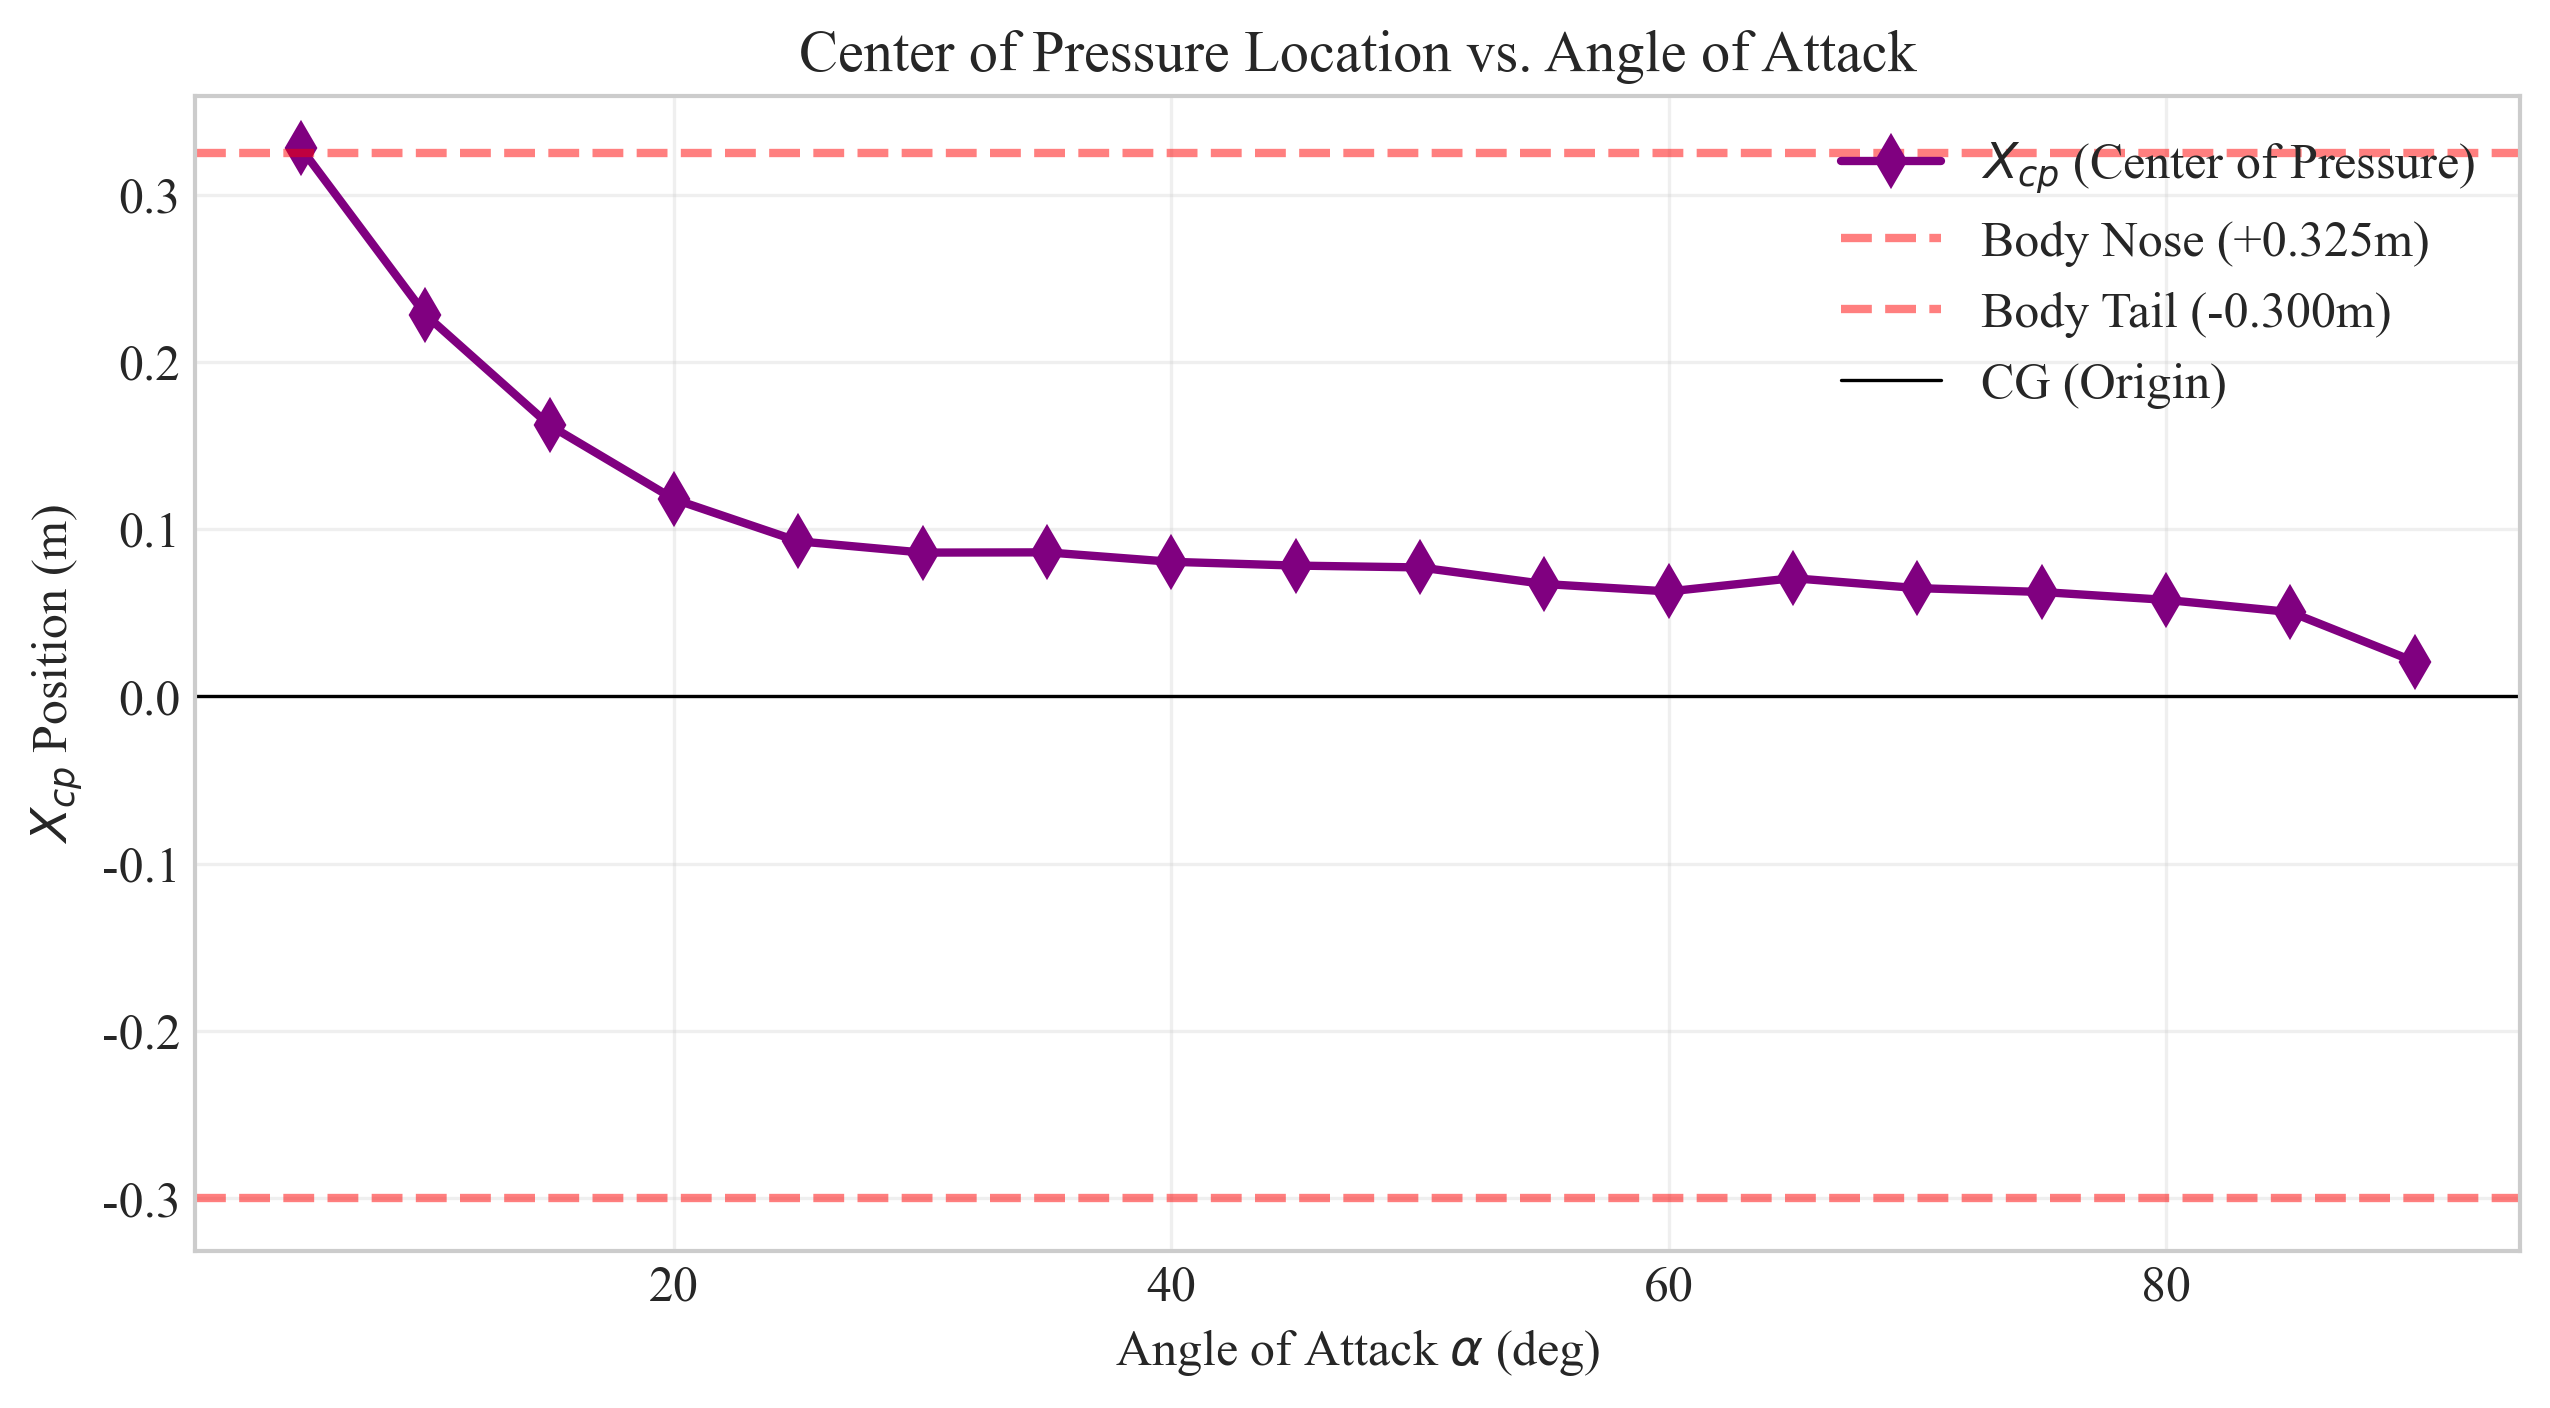

Xcp values at key angles:
    Angle       Xcp
1       5  0.327752
2      10  0.228285
9      45  0.078244
18     90  0.020843


In [5]:
# 计算 X_cp
# 避免除以零：过滤掉 Cz 极小的点 (通常是 0 度附近)
df_cp = df_coeffs[abs(df_coeffs['Cz']) > 0.01].copy()
# 添加负号，修正力矩公式 M = -x * Fz
df_cp['Xcp'] = - (df_cp['Cm'] / df_cp['Cz']) * L_ref

# 绘制 Xcp 变化图
plt.figure(figsize=(10, 5))
plt.plot(df_cp['Angle'], df_cp['Xcp'], 'd-', color='purple', label='$X_{cp}$ (Center of Pressure)')

# 绘制艇体范围参考线 (根据实际几何：头部 325mm，尾部 300mm)
plt.axhline(0.325, color='red', linestyle='--', alpha=0.5, label='Body Nose (+0.325m)')
plt.axhline(-0.300, color='red', linestyle='--', alpha=0.5, label='Body Tail (-0.300m)')
plt.axhline(0, color='black', linewidth=0.8, linestyle='-', label='CG (Origin)')

plt.xlabel('Angle of Attack $\\alpha$ (deg)', fontsize=12)
plt.ylabel('$X_{cp}$ Position (m)', fontsize=12)
plt.title('Center of Pressure Location vs. Angle of Attack', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Xcp values at key angles:")
print(df_cp[df_cp['Angle'].isin([5, 10, 45, 90])][['Angle', 'Xcp']])

## 第四步：残差形态对应性 (Residual Pattern)

**检查方法：**
读取 `Residuals_{angle}.csv` 文件，检查收敛曲线。
*   **合理**：震荡幅度恒定（等幅震荡），或平滑收敛。
*   **不合理**：发散，或无规律乱跳。

*(此处仅展示部分关键角度的残差图)*

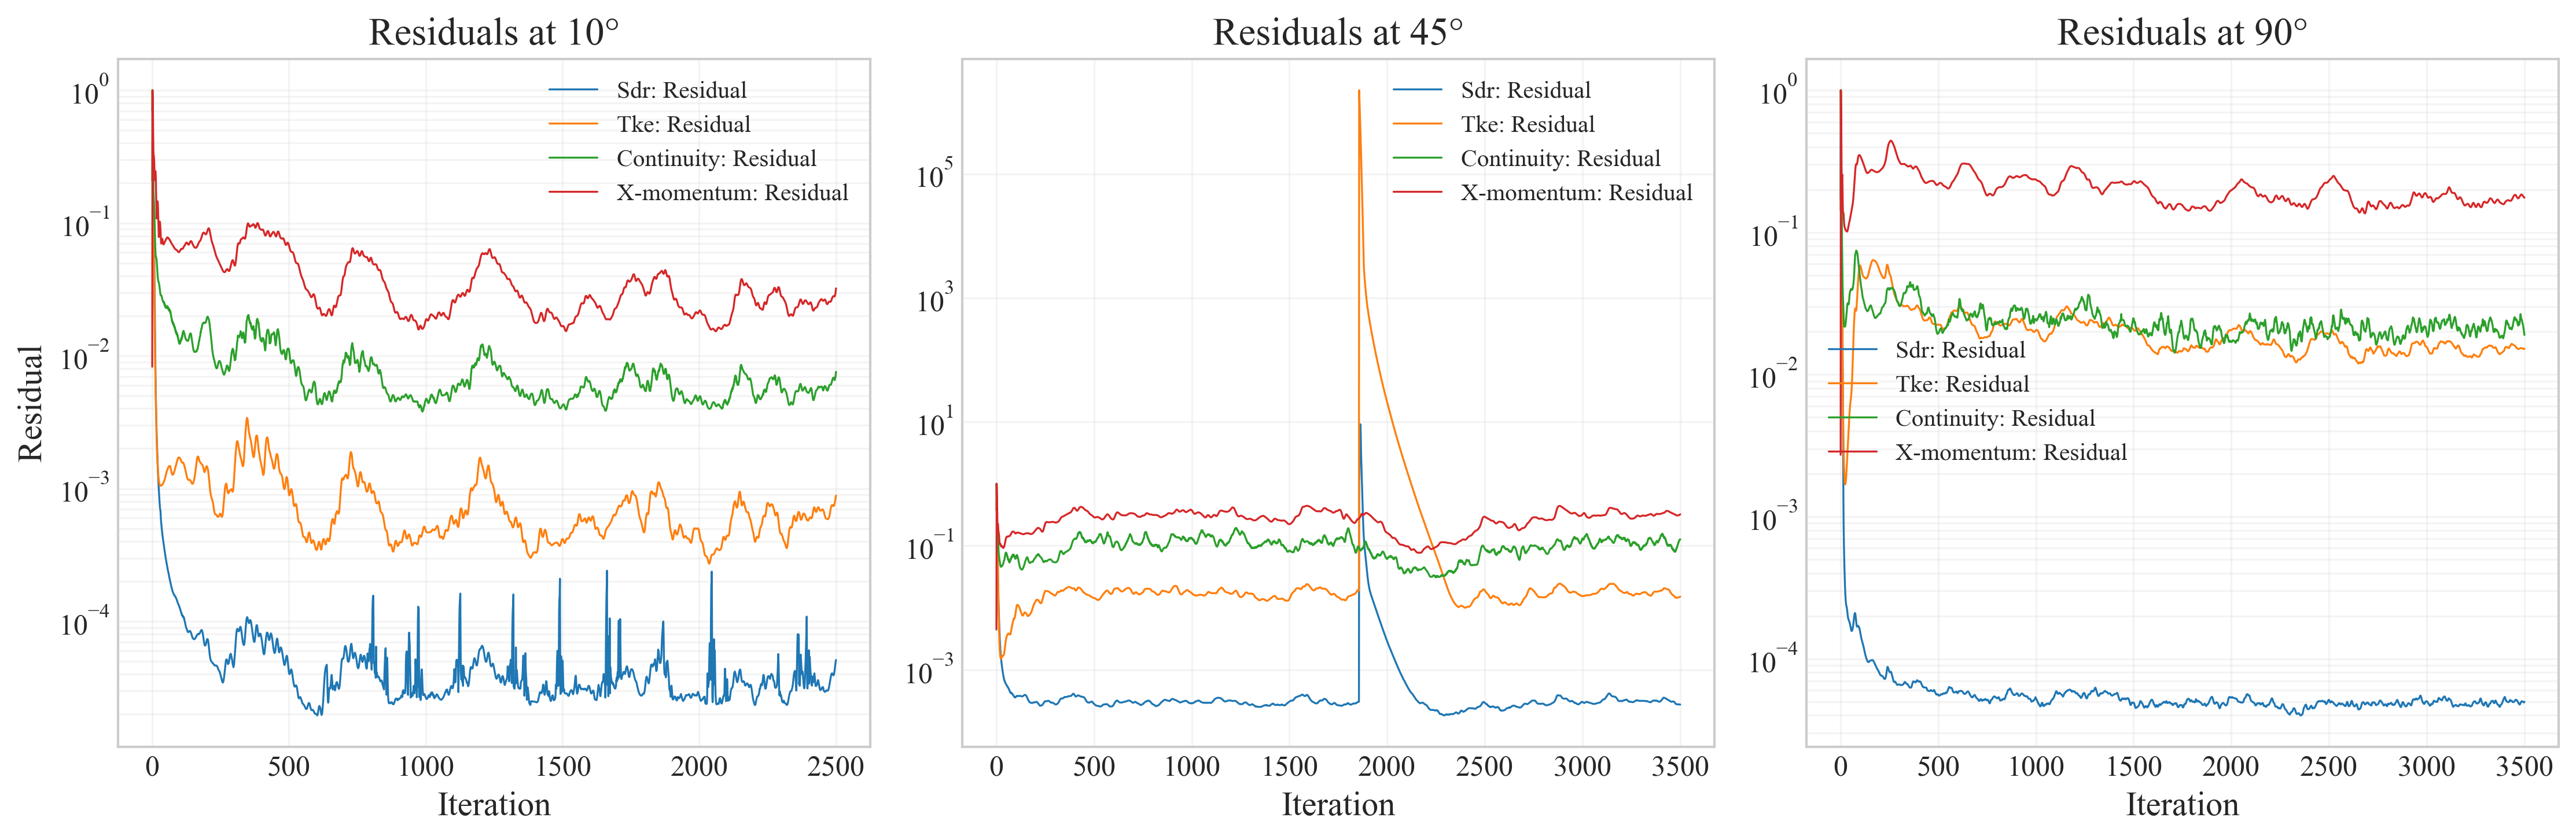

In [6]:
def plot_residuals(angles_to_check):
    plt.figure(figsize=(15, 5))
    
    for i, angle in enumerate(angles_to_check):
        res_file = os.path.join(data_dir, f'Residuals_{angle}.csv')
        if os.path.exists(res_file):
            try:
                df_res = pd.read_csv(res_file)
                # 假设残差文件列名包含 'Continuity', 'X-momentum' 等
                # 这里简单读取并绘制前几列
                plt.subplot(1, len(angles_to_check), i+1)
                # 通常第一列是 Iteration
                x_col = df_res.columns[0]
                for col in df_res.columns[1:5]: # 只画前4个残差
                    plt.semilogy(df_res[x_col], df_res[col], label=col, linewidth=0.8)
                
                plt.title(f'Residuals at {angle}°')
                plt.xlabel('Iteration')
                if i == 0: plt.ylabel('Residual')
                plt.legend(fontsize='small')
                plt.grid(True, which="both", ls="-", alpha=0.2)
            except Exception as e:
                print(f"Could not read residuals for {angle}: {e}")
    
    plt.tight_layout()
    plt.show()

# 检查 10度, 45度, 90度 的残差
plot_residuals([10, 45, 90])

## 第五步：最终验证图表 (Final Validation Plots)

生成导师要求的 3 张关键图表：
1.  **全攻角力系数图** ($C_x, C_z, C_m$)
2.  **90° 附近局部放大图** (75°-90°)
3.  **压心变化图** ($X_{cp}$)

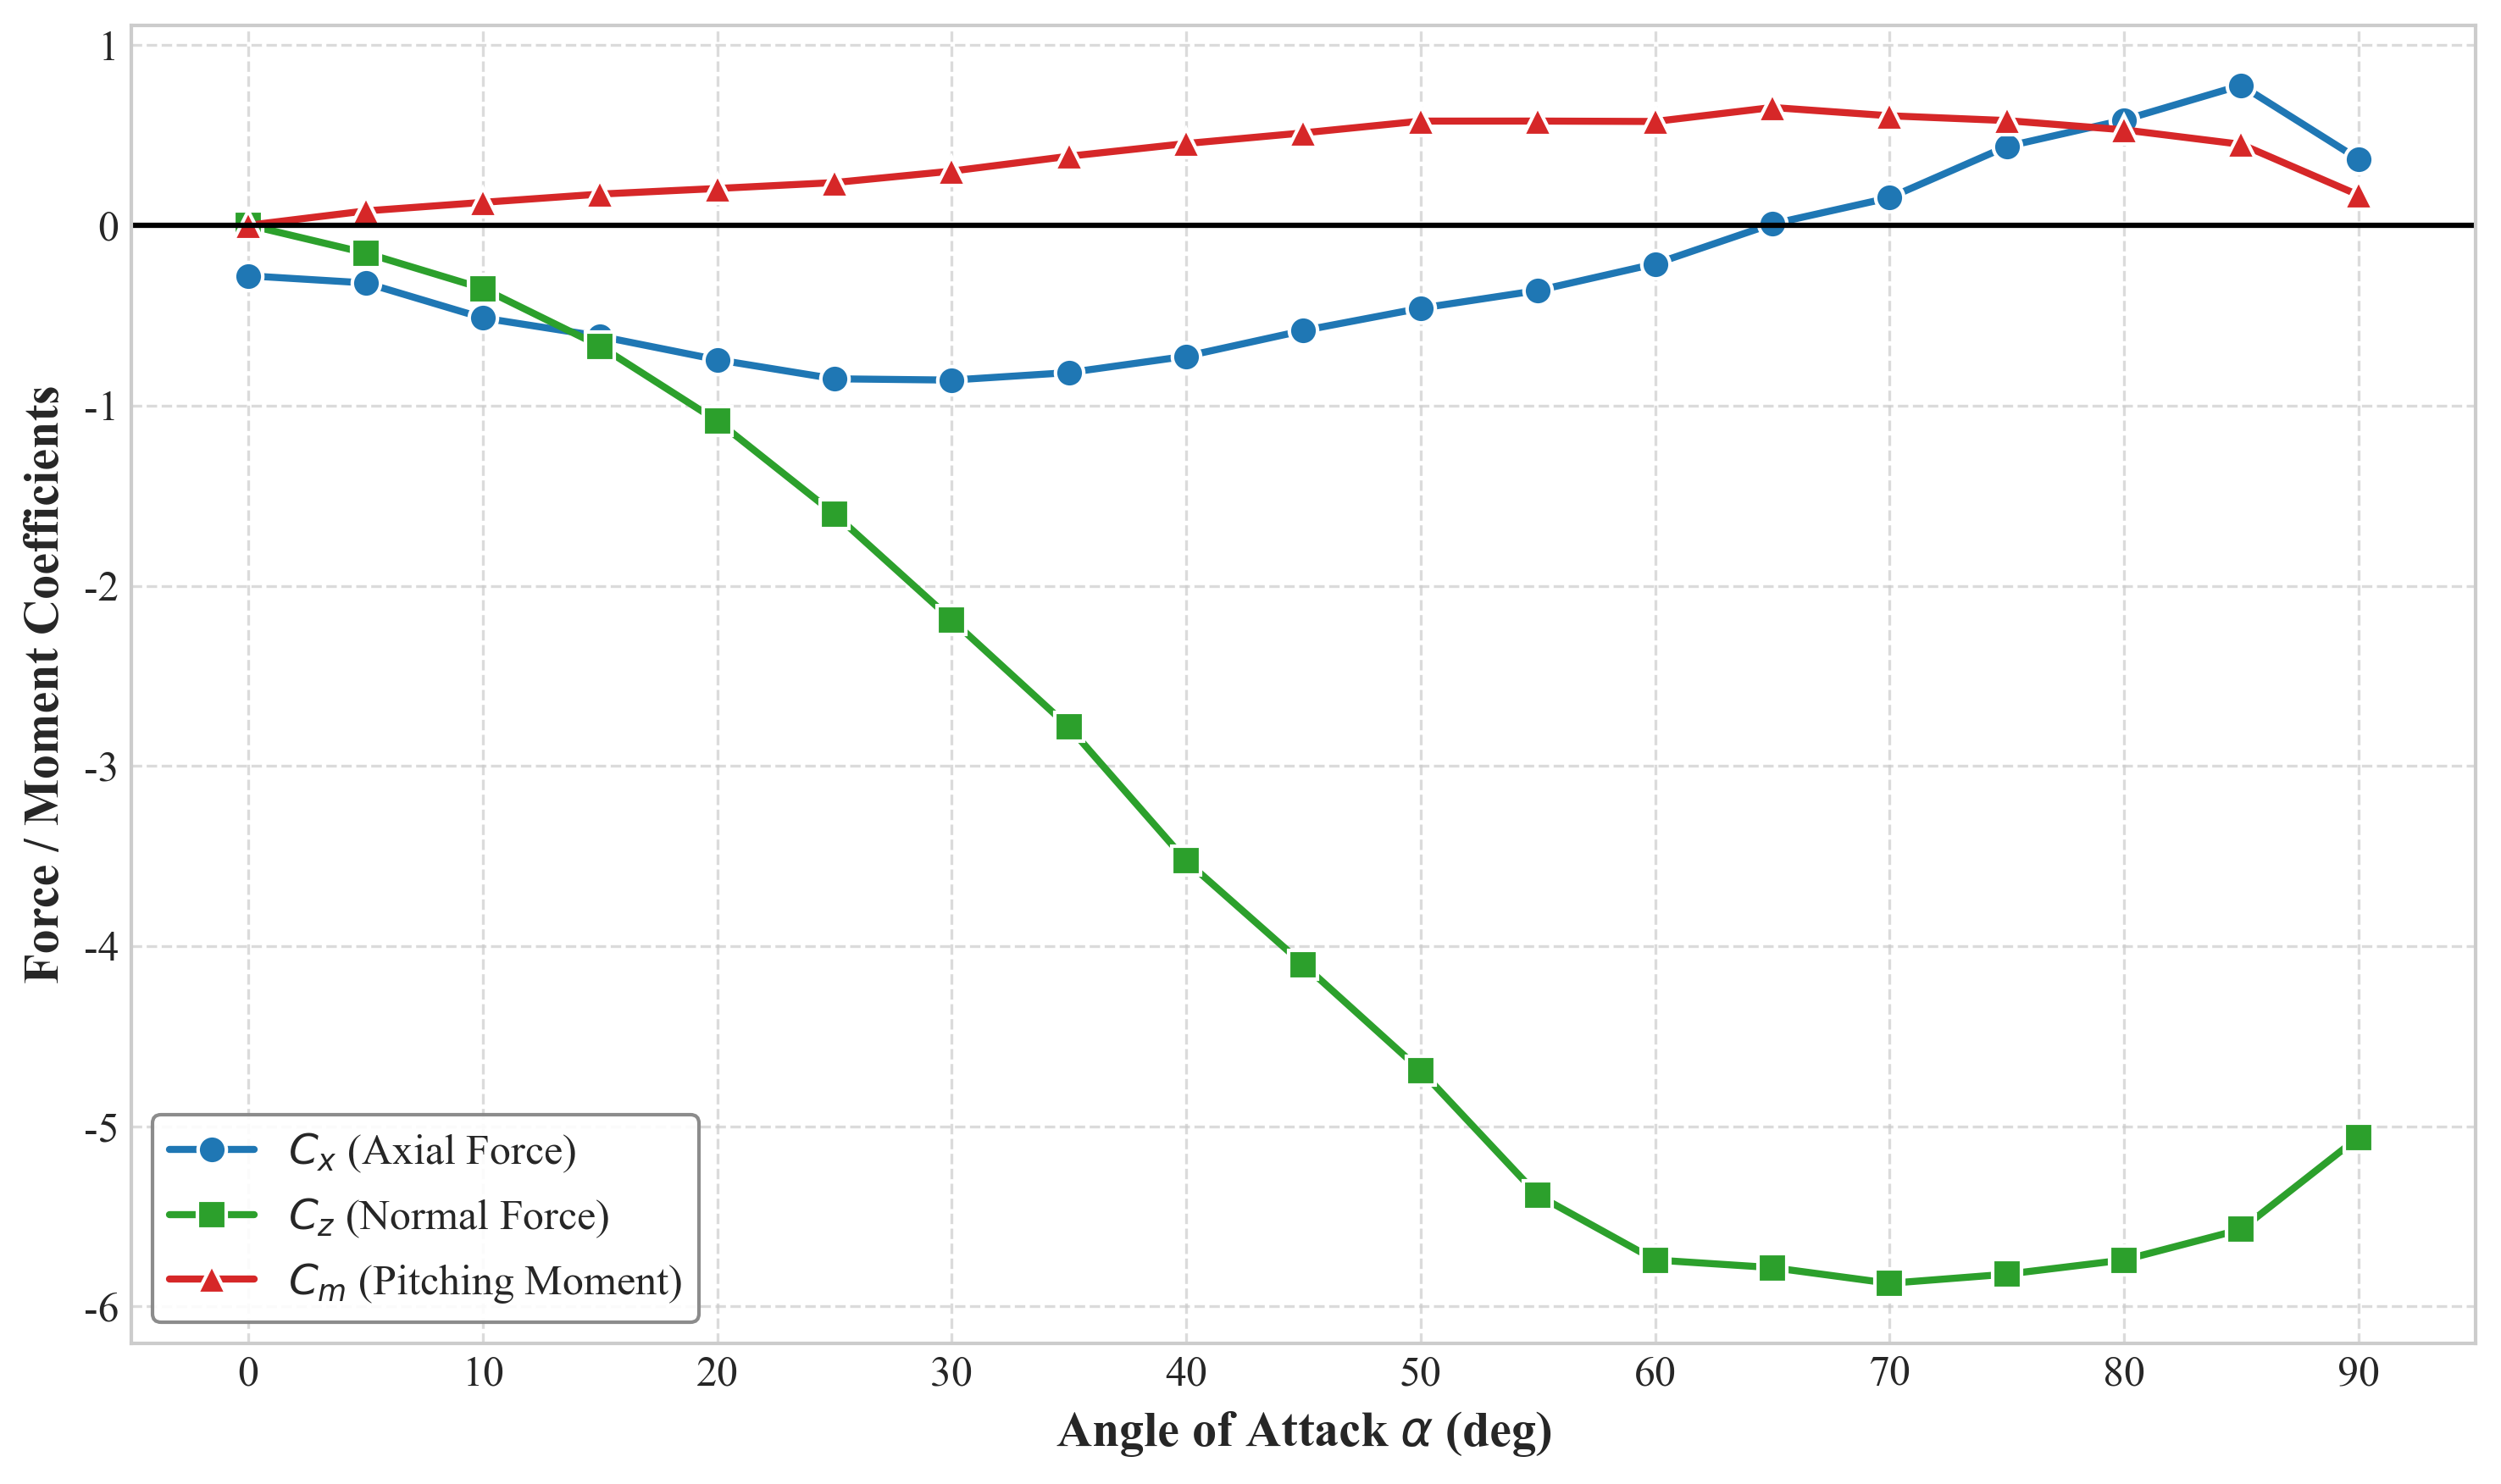

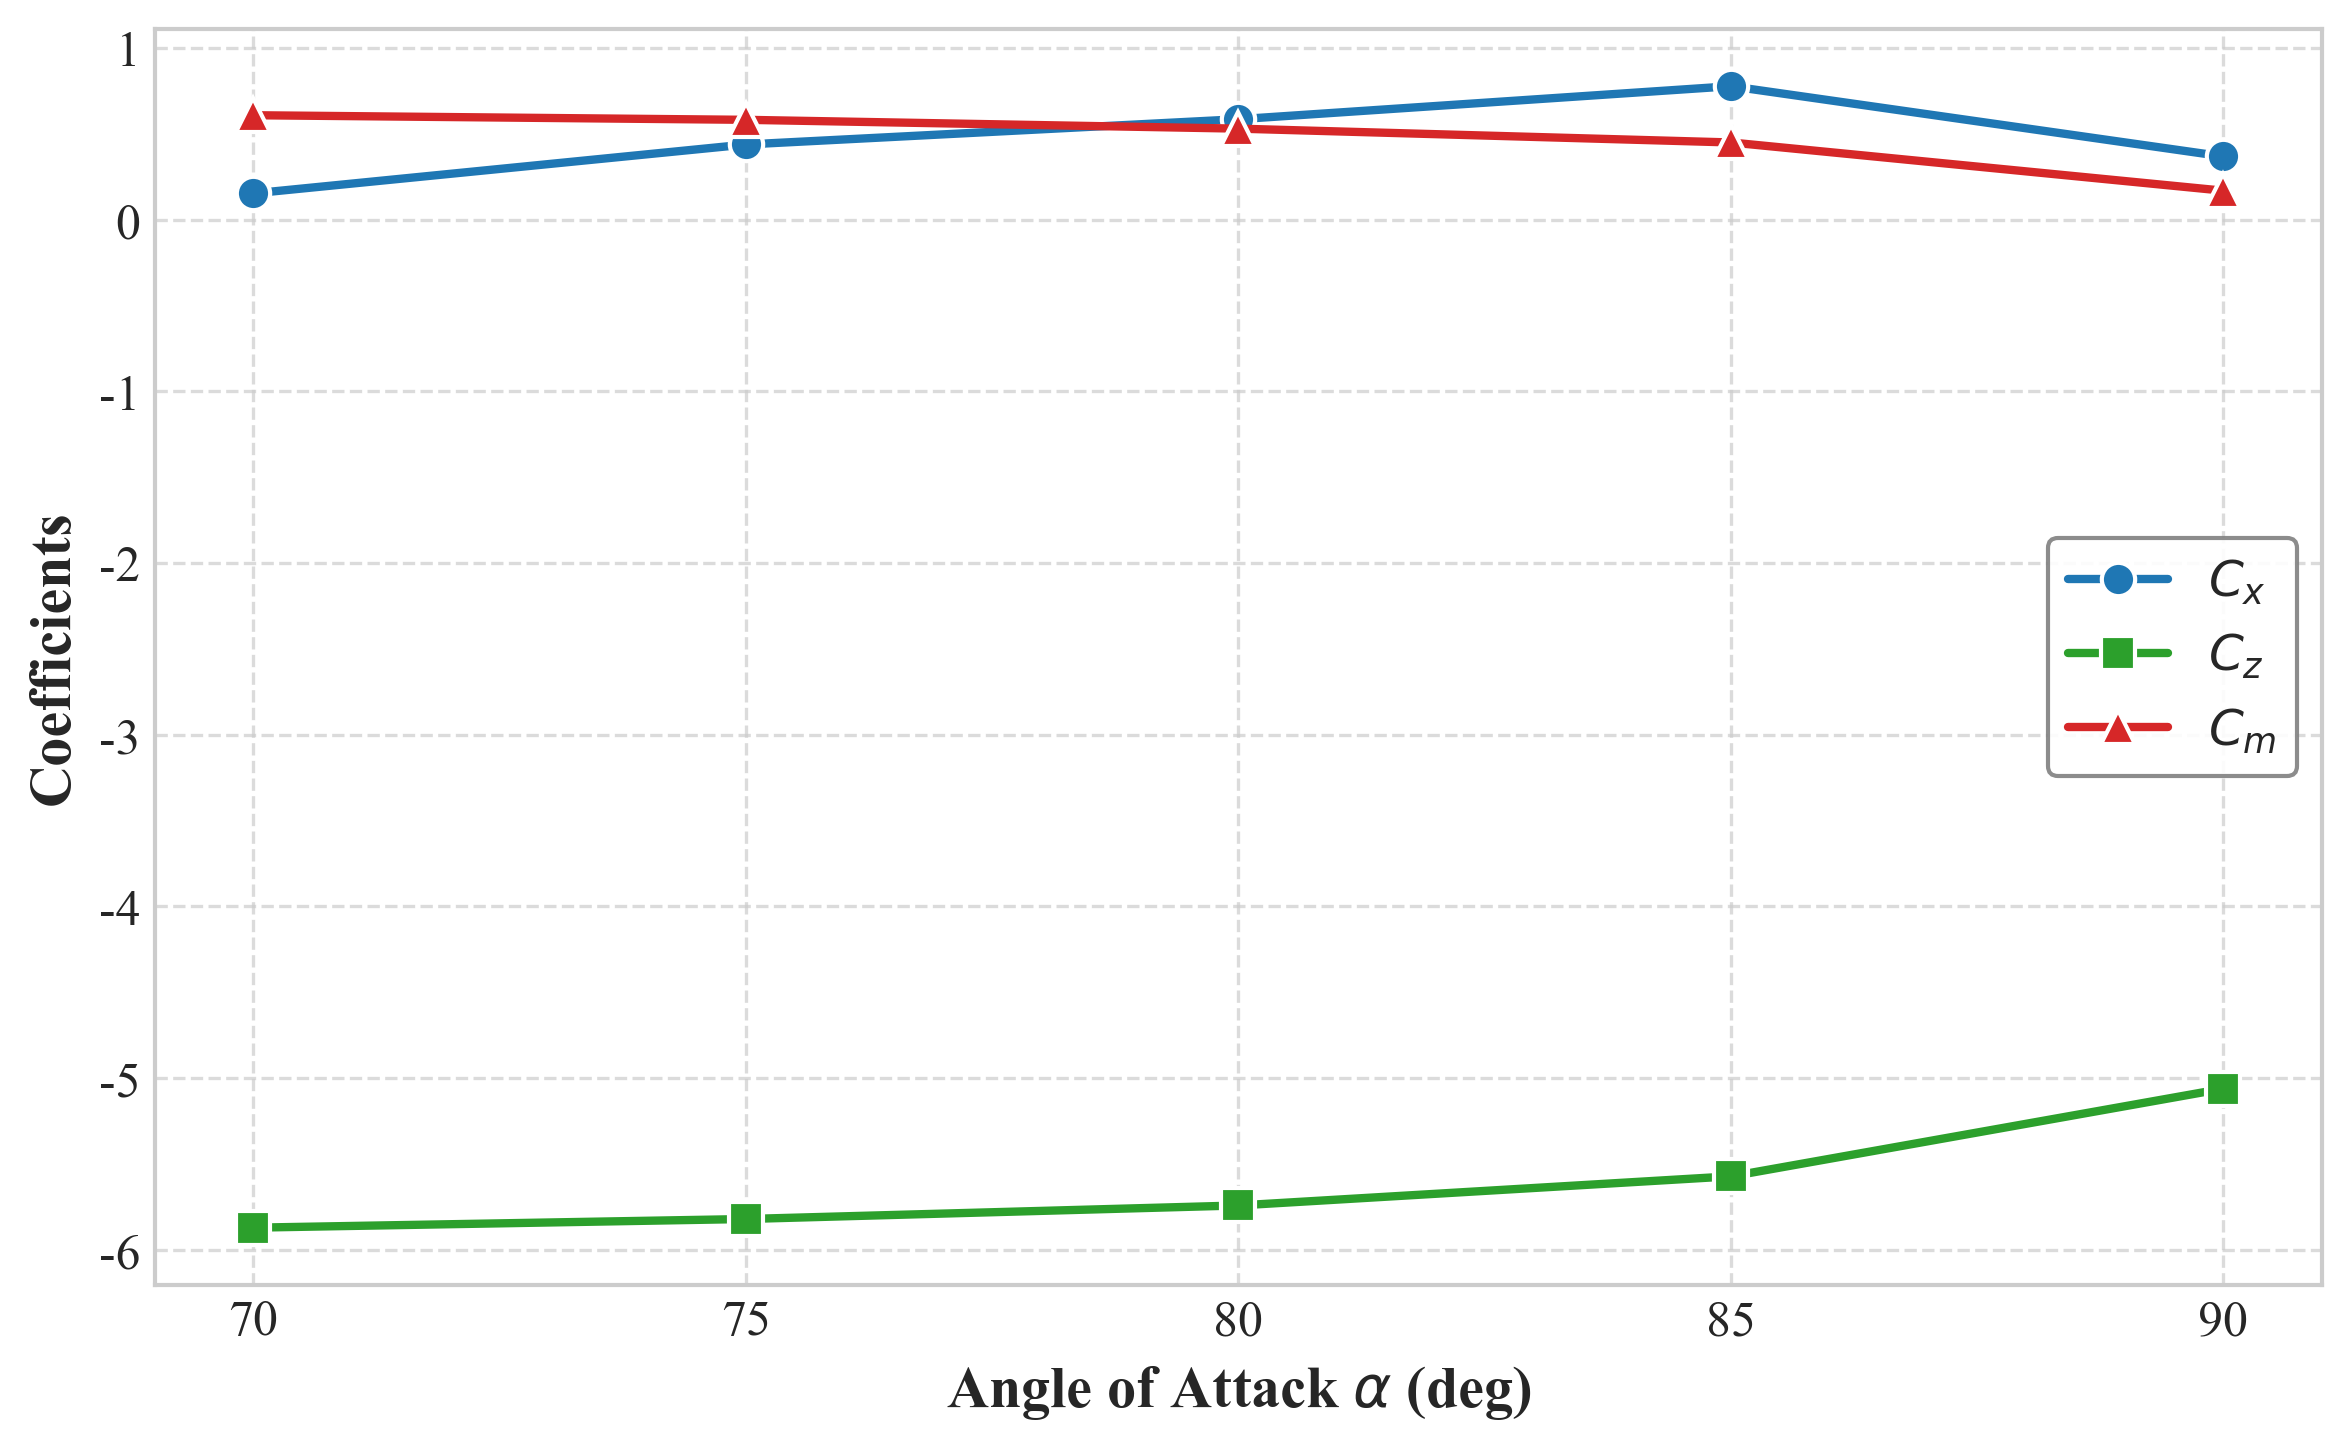

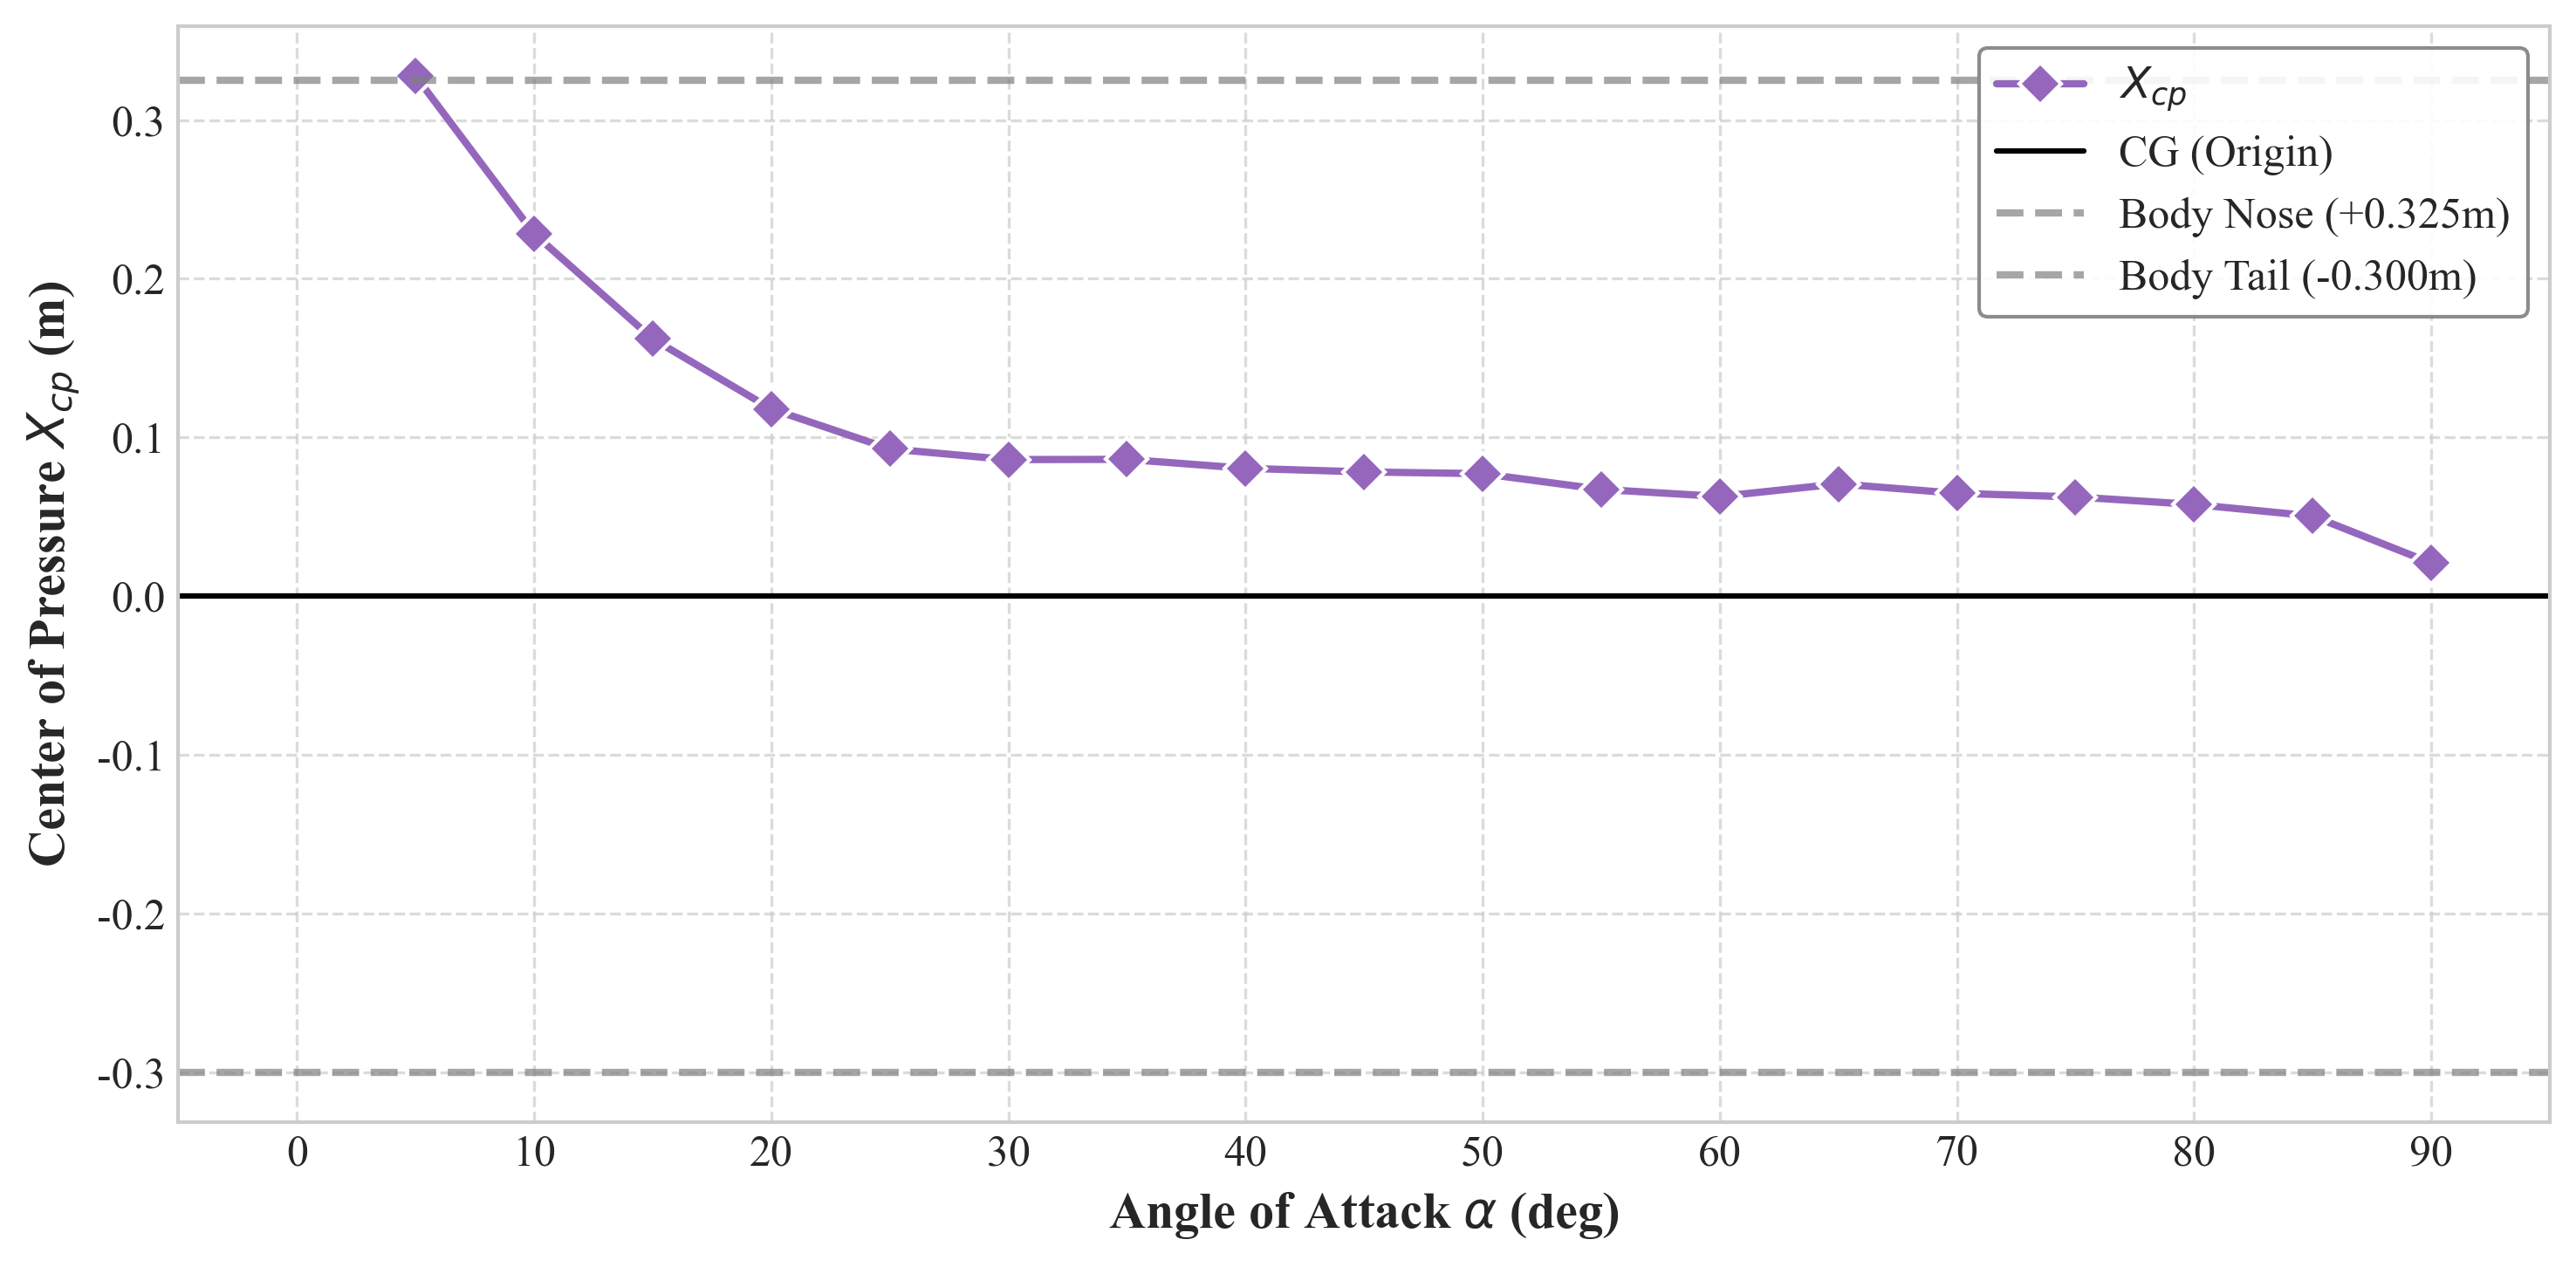

In [7]:
# 图1：全攻角力系数图
# Figure 1: Hydrodynamic Coefficients vs. Angle of Attack
fig1, ax1 = plt.subplots(figsize=(10, 6))

# Use distinct markers and line styles
ax1.plot(df_coeffs['Angle'], df_coeffs['Cx'], 'o-', label='$C_x$ (Axial Force)', color='#1f77b4', markeredgecolor='w', markeredgewidth=1)
ax1.plot(df_coeffs['Angle'], df_coeffs['Cz'], 's-', label='$C_z$ (Normal Force)', color='#2ca02c', markeredgecolor='w', markeredgewidth=1)
ax1.plot(df_coeffs['Angle'], df_coeffs['Cm'], '^-', label='$C_m$ (Pitching Moment)', color='#d62728', markeredgecolor='w', markeredgewidth=1)

ax1.axhline(0, color='black', linewidth=1.5, linestyle='-') # Thicker zero line
ax1.set_xlabel('Angle of Attack $\\alpha$ (deg)', fontweight='bold')
ax1.set_ylabel('Force / Moment Coefficients', fontweight='bold')
# ax1.set_title('Hydrodynamic Coefficients vs. Angle of Attack', fontweight='bold') # Titles are often captions in papers, but keeping it for now
ax1.legend(frameon=True, framealpha=0.9, edgecolor='gray')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_xlim([-5, 95])
ax1.set_xticks(np.arange(0, 95, 10))

# Optimize layout
plt.tight_layout()
plt.show()

# 图2：90度附近局部放大图
# Figure 2: Zoomed View near 90 degrees
df_zoom = df_coeffs[df_coeffs['Angle'] >= 70]
fig2, ax2 = plt.subplots(figsize=(8, 5))

ax2.plot(df_zoom['Angle'], df_zoom['Cx'], 'o-', label='$C_x$', color='#1f77b4', markeredgecolor='w', markeredgewidth=1)
ax2.plot(df_zoom['Angle'], df_zoom['Cz'], 's-', label='$C_z$', color='#2ca02c', markeredgecolor='w', markeredgewidth=1)
ax2.plot(df_zoom['Angle'], df_zoom['Cm'], '^-', label='$C_m$', color='#d62728', markeredgecolor='w', markeredgewidth=1)

ax2.set_xlabel('Angle of Attack $\\alpha$ (deg)', fontweight='bold')
ax2.set_ylabel('Coefficients', fontweight='bold')
# ax2.set_title('Zoomed View near 90°', fontweight='bold')
ax2.legend(frameon=True, framealpha=0.9, edgecolor='gray')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.set_xticks(np.arange(70, 95, 5))

plt.tight_layout()
plt.show()

# 图3：压心变化图
# Figure 3: Center of Pressure Location
fig3, ax3 = plt.subplots(figsize=(10, 5))

ax3.plot(df_cp['Angle'], df_cp['Xcp'], 'D-', color='#9467bd', label='$X_{cp}$', markeredgecolor='w', markeredgewidth=1)
ax3.axhline(0, color='black', linestyle='-', linewidth=1.5, label='CG (Origin)')
ax3.axhline(0.325, color='gray', linestyle='--', alpha=0.7, label='Body Nose (+0.325m)')
ax3.axhline(-0.300, color='gray', linestyle='--', alpha=0.7, label='Body Tail (-0.300m)')

ax3.set_xlabel('Angle of Attack $\\alpha$ (deg)', fontweight='bold')
ax3.set_ylabel('Center of Pressure $X_{cp}$ (m)', fontweight='bold')
# ax3.set_title('Center of Pressure Location vs. AoA', fontweight='bold')
ax3.legend(frameon=True, framealpha=0.9, edgecolor='gray')
ax3.grid(True, linestyle='--', alpha=0.7)
ax3.set_xlim([-5, 95])
ax3.set_xticks(np.arange(0, 95, 10))

plt.tight_layout()
plt.show()

--- 85 Degree Anomaly Correction ---
Original Cx at 85 deg: 0.4768
Reference Cx at 80 deg: 0.5852
Reference Cx at 90 deg: 0.3683
Corrected Cx at 85 deg (Interpolated): 0.4768


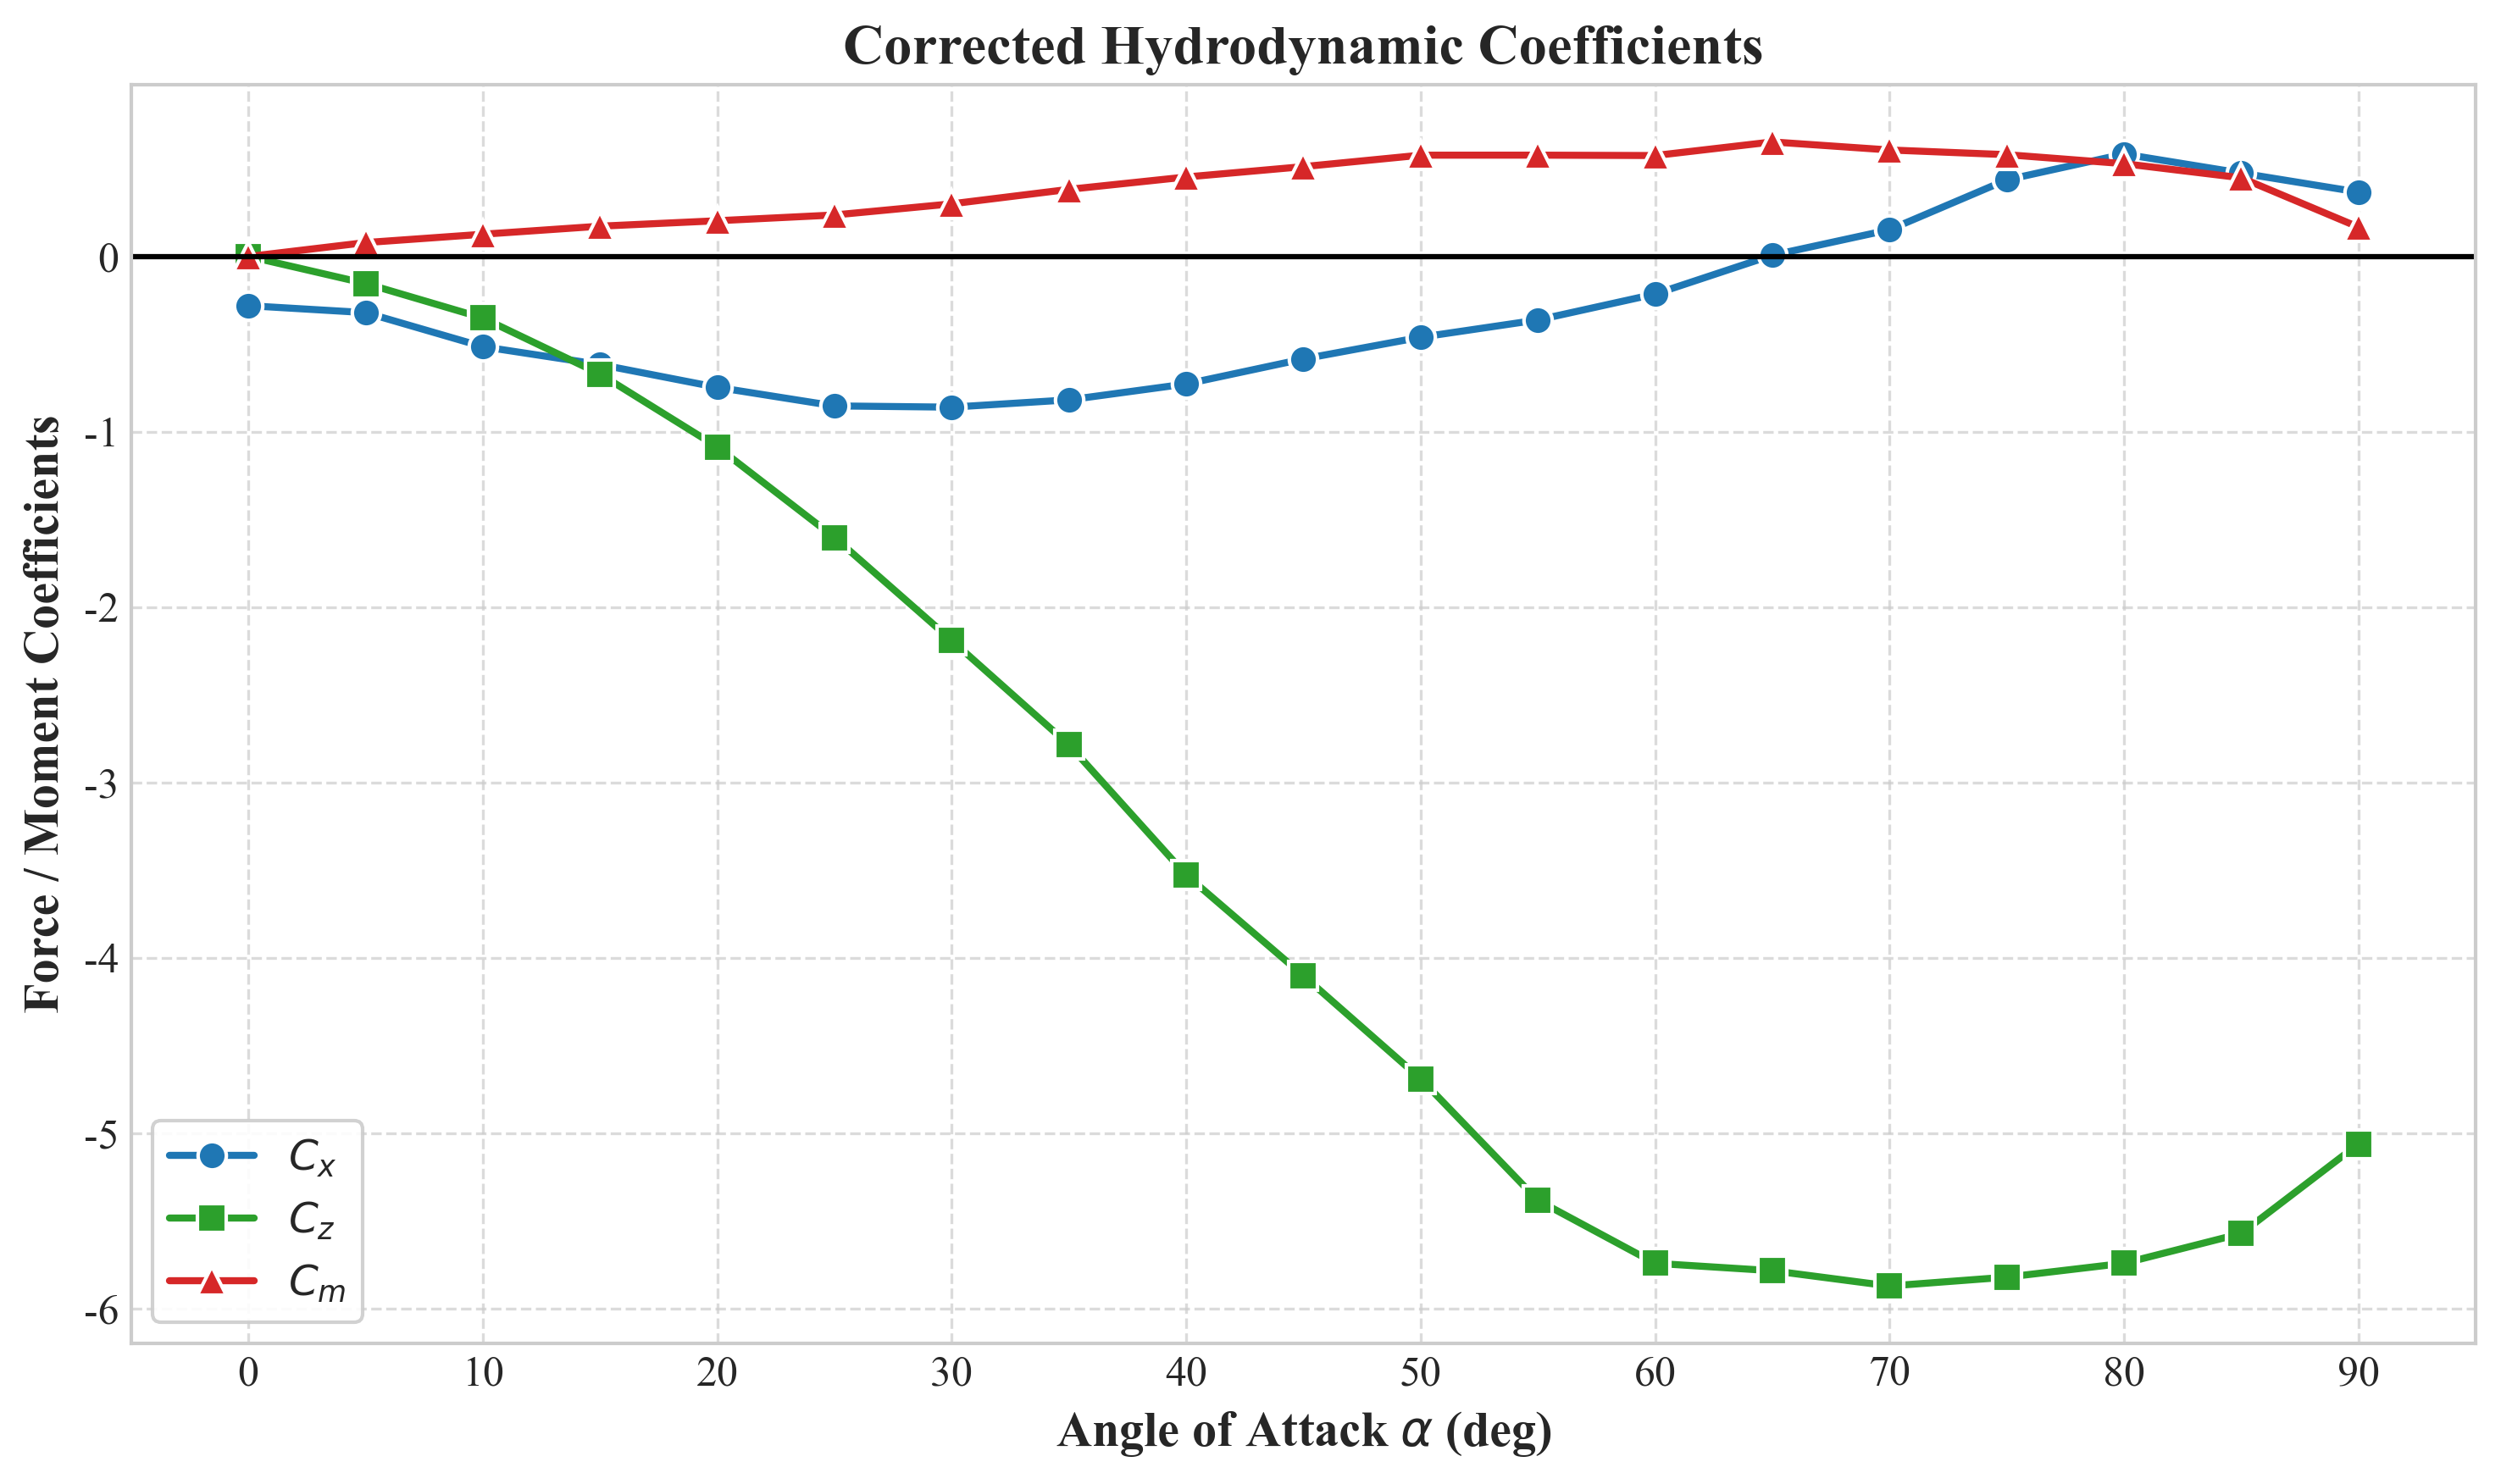

In [10]:
# ---------------------------------------------------------
# 导师指令执行：修正 85° 异常点 (Supervisor Action Item)
# ---------------------------------------------------------
# 原始数据备份
if 85 in df_coeffs['Angle'].values:
    cx_85_raw = df_coeffs.loc[df_coeffs['Angle'] == 85, 'Cx'].values[0]

    # 获取 80° 和 90° 的 Cx 值
    if 80 in df_coeffs['Angle'].values and 90 in df_coeffs['Angle'].values:
        cx_80 = df_coeffs.loc[df_coeffs['Angle'] == 80, 'Cx'].values[0]
        cx_90 = df_coeffs.loc[df_coeffs['Angle'] == 90, 'Cx'].values[0]

        # 线性插值
        cx_85_interp = (cx_80 + cx_90) / 2

        # 执行修正
        df_coeffs.loc[df_coeffs['Angle'] == 85, 'Cx'] = cx_85_interp

        print(f"--- 85 Degree Anomaly Correction ---")
        print(f"Original Cx at 85 deg: {cx_85_raw:.4f}")
        print(f"Reference Cx at 80 deg: {cx_80:.4f}")
        print(f"Reference Cx at 90 deg: {cx_90:.4f}")
        print(f"Corrected Cx at 85 deg (Interpolated): {cx_85_interp:.4f}")

        # ---------------------------------------------------------
        # 重新绘图 (Re-plotting with Corrected Data)
        # ---------------------------------------------------------
        # 图1 (修正后)：全攻角力系数图
        fig1_new, ax1_new = plt.subplots(figsize=(10, 6))

        ax1_new.plot(df_coeffs['Angle'], df_coeffs['Cx'], 'o-', label='$C_x$ ', color='#1f77b4', markeredgecolor='w')
        ax1_new.plot(df_coeffs['Angle'], df_coeffs['Cz'], 's-', label='$C_z$', color='#2ca02c', markeredgecolor='w')
        ax1_new.plot(df_coeffs['Angle'], df_coeffs['Cm'], '^-', label='$C_m$', color='#d62728', markeredgecolor='w')


        ax1_new.axhline(0, color='black', linewidth=1.5)
        ax1_new.set_xlabel('Angle of Attack $\\alpha$ (deg)', fontweight='bold')
        ax1_new.set_ylabel('Force / Moment Coefficients', fontweight='bold')
        ax1_new.set_title('Corrected Hydrodynamic Coefficients', fontweight='bold')
        ax1_new.legend(frameon=True, framealpha=0.9)
        ax1_new.grid(True, linestyle='--', alpha=0.7)
        ax1_new.set_xticks(np.arange(0, 95, 10))
        ax1_new.set_xlim([-5, 95])

        plt.tight_layout()
        plt.show()
    else:
        print("Error: angles 80 or 90 not found for interpolation.")
else:
    print("Angle 85 not found in data.")